# Shadow attack

### Training a DecisionTree and testing a shadow Attack

In this test we build a target classifier and an attacker model, then we evaluate the privacy risks using Liwei Song privacy score metrics. 

#### Workflow:
    - Download data
    - Split tha data into subsets
    - Train a machine classifier model with the first subset
    - Train the shadow models with the rest of the subsets
    - Use the probability predicted from the shadow model to train an attacker model
    - Use the atatcker model on the probabilities predicted from the target model

## part 1  - Preparing the data
- prepare dataset
    - download dataset
    - observe the dataset quality
    - shuffle dataset
    - split into subsets

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from membership_inference_attacks import black_box_benchmarks
from privacy_risk_score_utils import calculate_risk_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('ggplot')

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
random_state = 20
np.random.seed(random_state)

In [2]:
dataset_type = 1

if (dataset_type == 0):
    data_url = "winequality-red.csv"
    target_name = 'quality'

    df = pd.read_csv(data_url, sep = ';', header = 0)
elif (dataset_type == 1):
    target_name = "class"
    dataset = datasets.fetch_covtype()
    df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    df[target_name] = dataset.target

n_features = len(pd.unique(df[target_name]))
features = pd.unique(df[target_name])
features.sort()
print("There are "+ str(n_features) + " unique labels: ")  
print(features)

min_feature = features[0] #lower numeric feature
max_feature = features[n_features-1] #highest numeric feature

test_size_model = 0.7
test_size_shadow = 0.5

df.head()

There are 7 unique labels: 
[1 2 3 4 5 6 7]


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,class
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


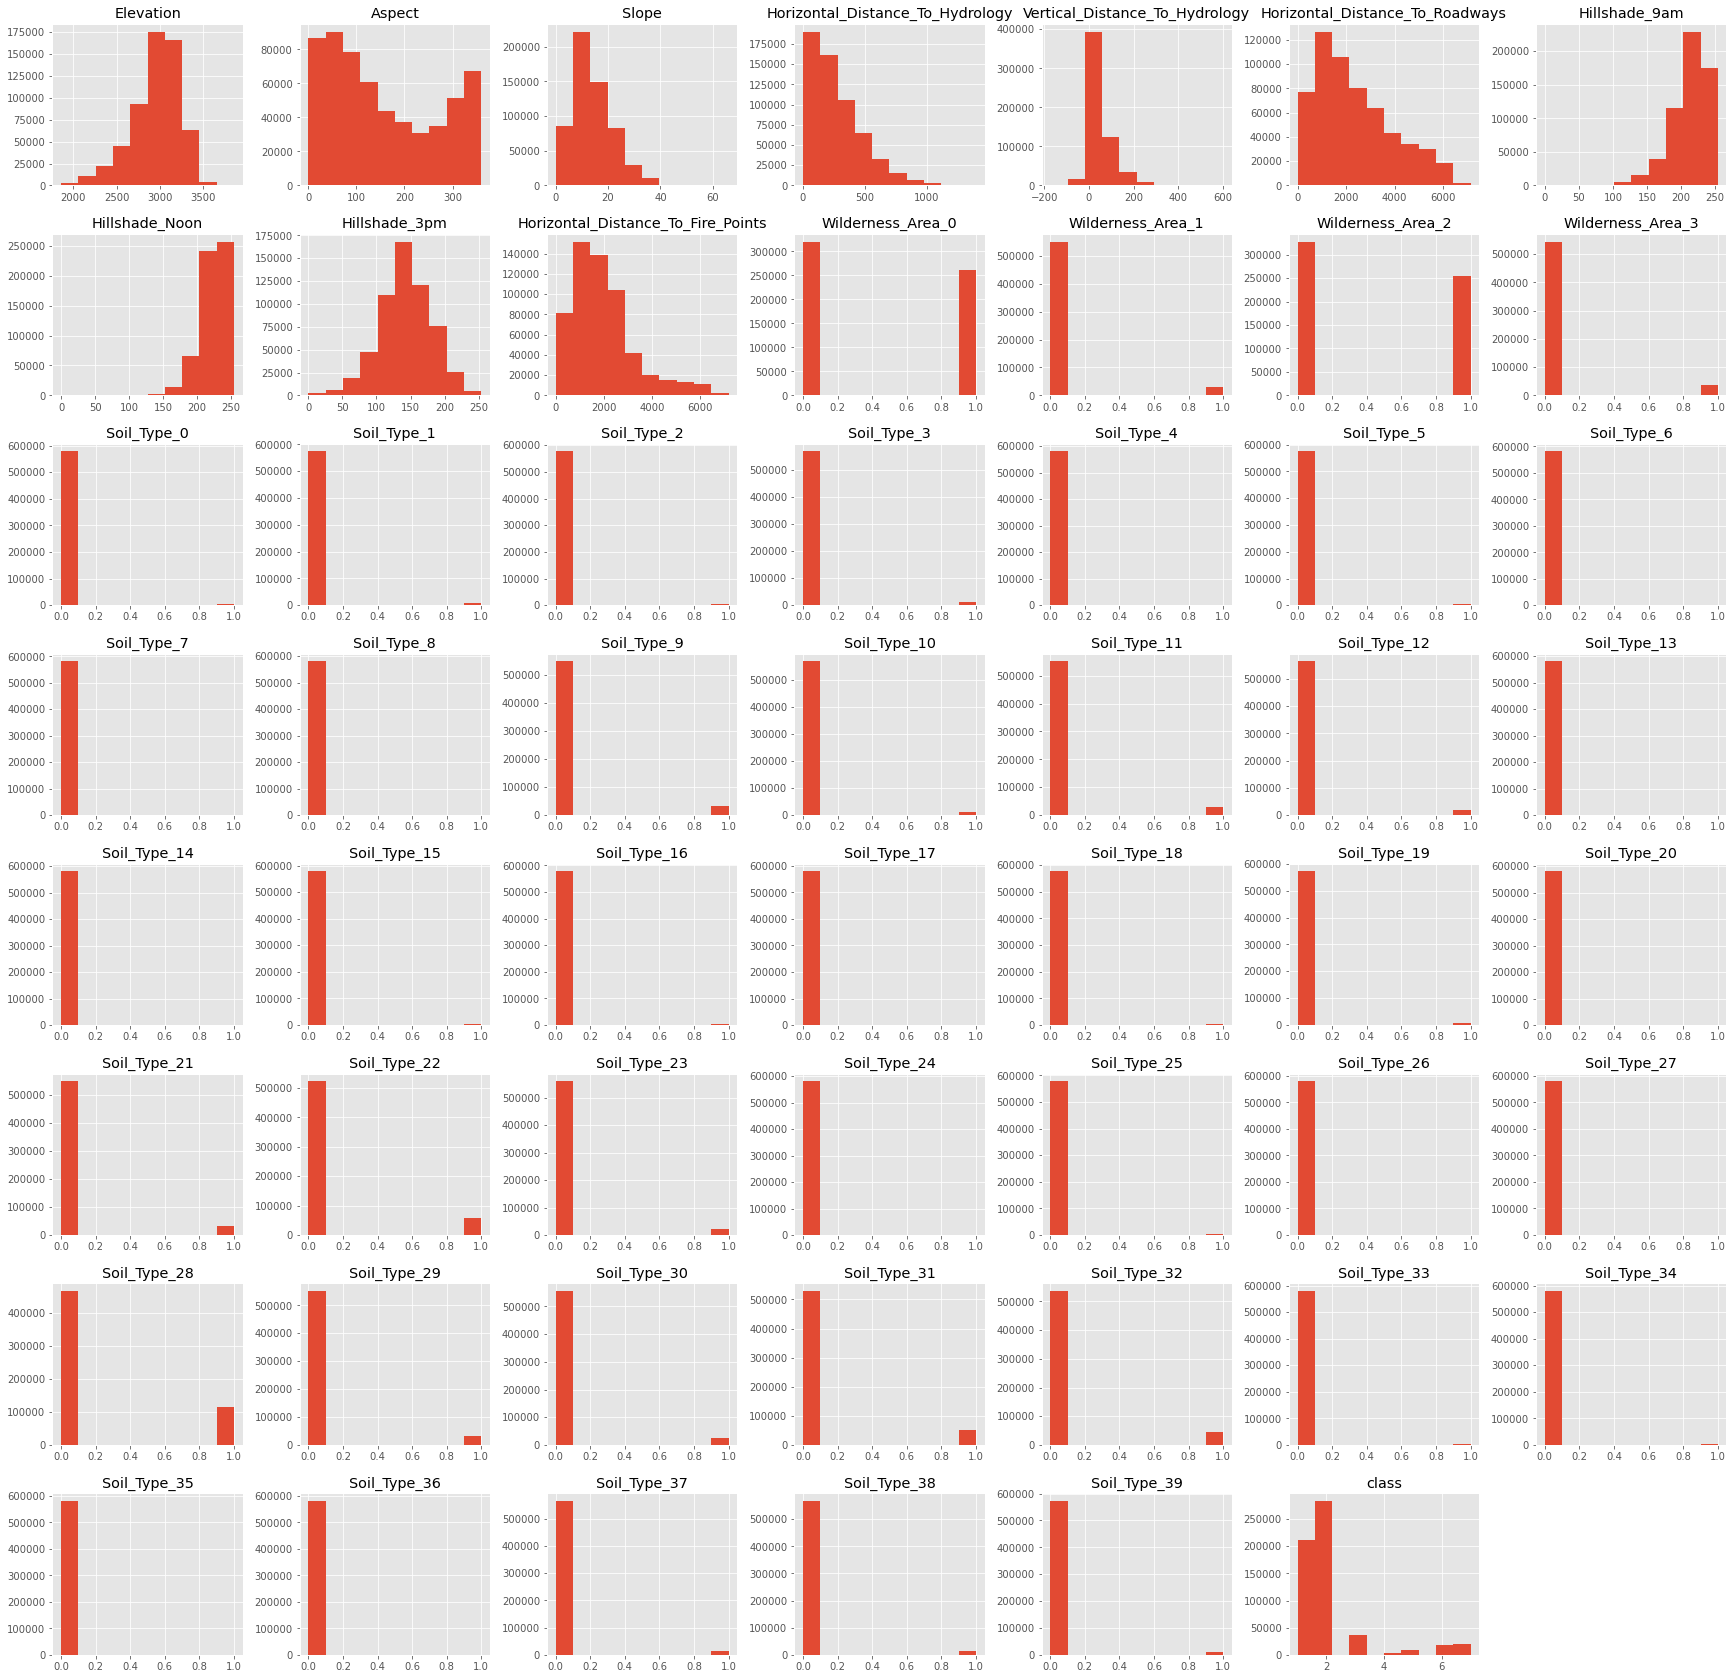

In [3]:
pd.DataFrame.hist(df
                  , figsize = [30,30]
                 );

In [4]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


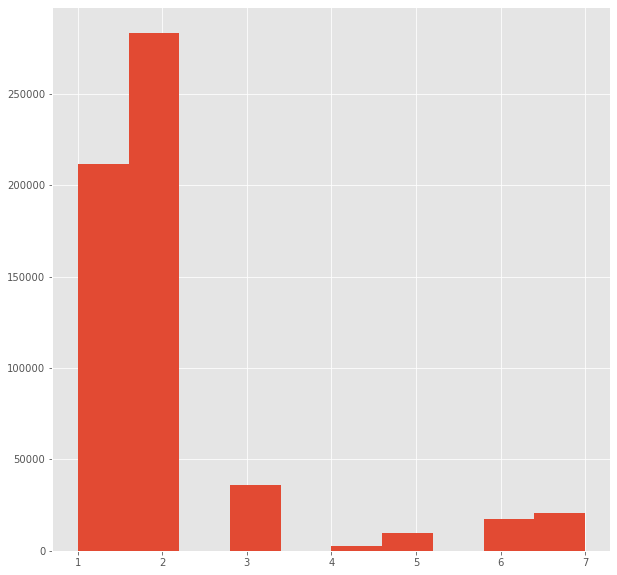

In [5]:
plt.hist(df[target_name])
plt.show()

In [6]:
# split dataset in n_datasets

n_rows = df.shape[0] # number of elements in the datasets
n_datasets = 10 #number of sub-datatsets to divide the datatsets

n_elements = math.floor(n_rows/n_datasets)

#shuffle the dataset
df = df.sample(frac=1, random_state = random_state).reset_index(drop=True)

dfList = []
for i in range(0, n_rows, n_elements):
    dfList.append(df[i:i+n_elements])

# print the labels on each dataset to make sure that in every subsets there is at least one example for each class
for i in range(n_datasets):
    temp = pd.unique(dfList[i][target_name])
    temp.sort()
    print("" + str(i) + ": [" + ", ".join(map(str, temp)) + "]")

0: [1, 2, 3, 4, 5, 6, 7]
1: [1, 2, 3, 4, 5, 6, 7]
2: [1, 2, 3, 4, 5, 6, 7]
3: [1, 2, 3, 4, 5, 6, 7]
4: [1, 2, 3, 4, 5, 6, 7]
5: [1, 2, 3, 4, 5, 6, 7]
6: [1, 2, 3, 4, 5, 6, 7]
7: [1, 2, 3, 4, 5, 6, 7]
8: [1, 2, 3, 4, 5, 6, 7]
9: [1, 2, 3, 4, 5, 6, 7]


## part 2 - Target model
- train the target model
    - split first dataset into training and testing    
    - train model
    - compute test and training accuracy
    - prepare the data for the MIA evaluation (probabilities + label)

In [7]:
df = dfList[0]
X = df.drop([target_name], axis = 1) # drop the class column
y = df[target_name] # Class only

print(X.shape, y.shape)

(58101, 54) (58101,)


In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = test_size_model, random_state = random_state)  

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
print('There are', Xtrain.shape[0], 'samples in the training dataset')
print('There are', Xtest.shape[0], 'samples in the testing dataset')
print('Each sample has', len(Xtrain.columns), 'features')

(17430, 54) (40671, 54) (17430,) (40671,)
There are 17430 samples in the training dataset
There are 40671 samples in the testing dataset
Each sample has 54 features


In [9]:
model = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=30, max_depth=15, random_state=random_state)
model.fit(X = Xtrain, y = ytrain)
ytrain_model = model.predict(Xtrain)

target_train_accurancy = accuracy_score(ytrain, ytrain_model)*100

print('The accuracy on training set is', target_train_accurancy, '%')

ytest_model = model.predict(Xtest)

target_test_accurancy = accuracy_score(ytest, ytest_model)*100

print('The accuracy on testing set is', target_test_accurancy, '%\n')

fitted_max_depth = model.tree_.max_depth
print('The maximum depth of the tree fitted on X_train is', fitted_max_depth)

print("")

yprob_model_train = model.predict_proba(Xtrain)
yprob_model_test = model.predict_proba(Xtest)

print(yprob_model_train)

The accuracy on training set is 78.26735513482501 %
The accuracy on testing set is 73.612647832608 %

The maximum depth of the tree fitted on X_train is 15

[[0.02777778 0.97222222 0.         ... 0.         0.         0.        ]
 [0.29411765 0.02941176 0.         ... 0.         0.         0.67647059]
 [0.43181818 0.56818182 0.         ... 0.         0.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.8317757  0.11214953 0.         ... 0.         0.         0.05607477]
 [0.15909091 0.84090909 0.         ... 0.         0.         0.        ]]


In [10]:
#function to prepare the porbabilities and labels to be stored in couples
def prepare_for_MIA(yprob_train_model,labels):
    
    return_outputs, return_labels = [], []
    min_labels = pd.unique(labels)
    min_labels.sort()
    min_label = min_labels[0]
    # -min_label becasue in the MIA evaluation consider the positions of the label from 0...n_labels (here they start at 1)
    for (yprob, label) in zip(yprob_train_model, labels):
            return_labels.append(np.array([label-min_label])) #without np.array([]) it would give the error cannot contenate 0d dimension array
            return_outputs.append(yprob)
    return_labels = np.concatenate(return_labels)
    return (return_outputs, return_labels)


target_train_probabilities = model.predict_proba(Xtrain)
target_test_probabilities = model.predict_proba(Xtest)

target_train_performance = []
target_test_performance = []
        
target_train_performance = prepare_for_MIA(target_train_probabilities, ytrain)
target_test_performance = prepare_for_MIA(target_test_probabilities, ytest)

In [11]:
miss_target_train_probabilities = target_train_probabilities[ytrain != ytrain_model]
miss_target_test_probabilities = target_test_probabilities[ytest != ytest_model]
miss_ytrain = ytrain[ytrain != ytrain_model]
miss_ytest = ytest[ytest != ytest_model]

miss_target_train_performance = []
miss_target_test_performance = []
        
miss_target_train_performance = prepare_for_MIA(miss_target_train_probabilities, miss_ytrain)
miss_target_test_performance = prepare_for_MIA(miss_target_test_probabilities, miss_ytest)

class_target_train_probabilities = target_train_probabilities[ytrain == ytrain_model]
class_target_test_probabilities = target_test_probabilities[ytest == ytest_model]
class_ytrain = ytrain[ytrain == ytrain_model]
class_ytest = ytest[ytest == ytest_model]

class_target_train_performance = []
class_target_test_performance = []
        
class_target_train_performance = prepare_for_MIA(class_target_train_probabilities, class_ytrain)
class_target_test_performance = prepare_for_MIA(class_target_test_probabilities, class_ytest)

## part 3
- train shadow models
    - train 3 shadow models on the sub-databases
    - use the tests dataset as example not use for training
    - create a dataset with guess probabiities and if is part of the dataset yes or no
    - try with and without pruning of the tree
    - try adding the data row next to the guesses

In [12]:
models = []

X_shadow = []
y_shadow = []

X_shadow_train = []
X_shadow_test = []
y_shadow_train = []
y_shadow_test = []

yprob_train_model = []
yprob_test_model = []

y_shadow_train_model = []
y_shadow_test_model = []

for i in range(n_datasets-1):
    
    X_shadow.append(dfList[i+1].drop([target_name], axis = 1)) # drop the class column
    y_shadow.append(dfList[i+1][target_name]) # Class only
    print(i)
    X_shadow_train_temp, X_shadow_test_temp, y_shadow_train_temp, y_shadow_test_temp = train_test_split(X_shadow[i], y_shadow[i], test_size = test_size_shadow, random_state = random_state)
    
    
    X_shadow_train.append(X_shadow_train_temp)
    X_shadow_test.append(X_shadow_test_temp)
    y_shadow_train.append(y_shadow_train_temp)
    y_shadow_test.append(y_shadow_test_temp)
    

    models.append(DecisionTreeClassifier(criterion="entropy", min_samples_leaf=30, max_depth=20))
    models[i].fit(X = X_shadow_train[i], y = y_shadow_train[i])
    
    y_shadow_train_model.append(models[i].predict(X_shadow_train[i]))
    
    accurancy = accuracy_score(y_shadow_train[i], y_shadow_train_model[i])*100

    print('The accuracy on training set', i,' is', accurancy, '%')

    y_shadow_test_model.append(models[i].predict(X_shadow_test[i]))

    accurancy = accuracy_score(y_shadow_test[i], y_shadow_test_model[i])*100

    print('The accuracy on testing set', i,' is', accurancy, '%')

    fitted_max_depth = models[i].tree_.max_depth
    print('The maximum depth of the tree', i,' fitted on X_shadow_train is', fitted_max_depth)
    
    yprob_train_model.append(models[i].predict_proba(X_shadow_train[i]))
    yprob_test_model.append(models[i].predict_proba(X_shadow_test[i]))

0
The accuracy on training set 0  is 80.34423407917384 %
The accuracy on testing set 0  is 75.5739905683109 %
The maximum depth of the tree 0  fitted on X_shadow_train is 20
1
The accuracy on training set 1  is 79.81411359724613 %
The accuracy on testing set 1  is 75.54645278992118 %
The maximum depth of the tree 1  fitted on X_shadow_train is 20
2
The accuracy on training set 2  is 80.50258175559381 %
The accuracy on testing set 2  is 75.69102612646724 %
The maximum depth of the tree 2  fitted on X_shadow_train is 20
3
The accuracy on training set 3  is 79.78657487091222 %
The accuracy on testing set 3  is 75.0817527795945 %
The maximum depth of the tree 3  fitted on X_shadow_train is 20
4
The accuracy on training set 4  is 79.6867469879518 %
The accuracy on testing set 4  is 75.45007056555713 %
The maximum depth of the tree 4  fitted on X_shadow_train is 20
5
The accuracy on training set 5  is 79.97934595524957 %
The accuracy on testing set 5  is 75.66348834807752 %
The maximum depth

In [13]:
#probability obtained by the shadow model on the train and test data, for the MIA evaluation

shadow_train_performance = []
shadow_test_performance = []

temp_shadow_train_performance = []
temp_shadow_test_performance = []
 
temp_prob = []
temp_tran = []

for i in range(n_datasets-1):
    for v in yprob_train_model[i]:
        temp_prob.append(v)
    for v in y_shadow_train[i]:
        temp_tran.append(v)
        
shadow_train_performance = prepare_for_MIA(temp_prob, temp_tran)

temp_prob = []
temp_tran = []

for i in range(n_datasets-1):
    for v in yprob_test_model[i]:
        temp_prob.append(v)
    for v in y_shadow_test[i]:
        temp_tran.append(v)
        
shadow_test_performance= prepare_for_MIA(temp_prob, temp_tran)

In [14]:
#probabilities that the target model obtain on the data used of the shadow classifier, for the MIA evaluation

target_shadow_train_performance = []
target_shadow_test_performance = []

y_target_on_shadow_train = []
targ_prob = []
temp_tran = []
      
for i in range(n_datasets-1):
    y_target_on_shadow_train.append(model.predict_proba(X_shadow_train[i]))

for i in range(n_datasets-1):
    for v in y_target_on_shadow_train[i]:
        targ_prob.append(v)
    for v in y_shadow_train[i]:
        temp_tran.append(v)

target_shadow_train_performance = prepare_for_MIA(targ_prob, temp_tran)
                                    
y_target_on_shadow_test = []                                 
targ_prob = []
temp_tran = []

for i in range(n_datasets-1):
    y_target_on_shadow_test.append(model.predict_proba(X_shadow_test[i]))
                                    
for i in range(n_datasets-1):
    for v in y_target_on_shadow_test[i]:
        targ_prob.append(v)
    for v in y_shadow_test[i]:
        temp_tran.append(v)
        
target_shadow_test_performance = prepare_for_MIA(targ_prob, temp_tran)

In [15]:
#preparing MIA evaluation for the case with only misclassified examples

miss_target_shadow_train_performance = []
miss_target_shadow_test_performance = []

miss_y_shadow_train = []
miss_y_shadow_test = []

miss_y_target_on_shadow_train = []
temp_y_target_on_shadow_train = []
targ_prob = []
temp_tran = []
      
for i in range(n_datasets-1):
    temp_y_target_on_shadow_train.append(model.predict_proba(X_shadow_train[i]))

for i in range(n_datasets-1):
    miss_y_target_on_shadow_train.append(temp_y_target_on_shadow_train[i][y_shadow_train[i] != y_shadow_train_model[i]])
    miss_y_shadow_train.append(y_shadow_train[i][y_shadow_train[i] != y_shadow_train_model[i]])
    
for i in range(n_datasets-1):
    for v in miss_y_target_on_shadow_train[i]:
        targ_prob.append(v)
    for v in miss_y_shadow_train[i]:
        temp_tran.append(v)
        
miss_shadow_train_performance = prepare_for_MIA(targ_prob, temp_tran)
                                    
temp_y_target_on_shadow_test = []      
miss_y_target_on_shadow_test = []
targ_prob = []
temp_tran = []

for i in range(n_datasets-1):
    temp_y_target_on_shadow_test.append(model.predict_proba(X_shadow_test[i]))
         
for i in range(n_datasets-1):
    miss_y_target_on_shadow_test.append(temp_y_target_on_shadow_test[i][y_shadow_test[i] != y_shadow_test_model[i]])
    miss_y_shadow_test.append(y_shadow_test[i][y_shadow_test[i] != y_shadow_test_model[i]])
        
for i in range(n_datasets-1):
    for v in miss_y_target_on_shadow_test[i]:
        targ_prob.append(v)
    for v in miss_y_shadow_test[i]:
        temp_tran.append(v)
        
miss_shadow_test_performance = prepare_for_MIA(targ_prob, temp_tran)

In [16]:
#create dataframe with yprob_train_model and a column with 'yes'; yprob_test_model and a column with 'no'
#shouffle it, split it in train and  and feed to the attacker
#perform the attack (predict over a dataset made from the original decision tree)

guesses = []
truth_labels = []
training = []

for i in range(n_datasets-1):
    for j in yprob_train_model[i]: #to concatenate the lists
        guesses.append(j)
    #for j in y_shadow_train[i]: #to concatenate the lists
    #    truth_labels.append(j)
    for j in y_shadow_train_model[i]: #to concatenate the lists
        truth_labels.append(j)
    
n_yes = len(guesses) # 1197 (num. elements in the dabase used for training [399*3]) - 300 (num. elements used in the testing [100*3]) = 897
    
for i in range(n_datasets-1):
    for j in yprob_test_model[i]:
        guesses.append(j)
    #for j in y_shadow_test[i]: #to concatenate the lists
    #    truth_labels.append(j)
    for j in y_shadow_test_model[i]: #to concatenate the lists
        truth_labels.append(j)
        
n_no = len(guesses) - n_yes # number of elements that are in the test section
    
print("Number of elements that were used for training " + str(n_yes))
print("Number of elments that were used for testing " + str(n_no))
    
training_yes = ['yes'] * n_yes
training_no = ['no'] * n_no
training = training_yes + training_no

df_shadow = pd.DataFrame({'guesses': guesses})
df_shadow['labels'] = truth_labels
df_shadow['training'] = training

print(df_shadow)

Number of elements that were used for training 261450
Number of elments that were used for testing 261459
                                                  guesses  labels training
0       [0.02564102564102564, 0.9487179487179487, 0.0,...       2      yes
1       [0.06666666666666667, 0.9333333333333333, 0.0,...       2      yes
2                     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]       1      yes
3                     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]       1      yes
4       [0.3157894736842105, 0.5526315789473685, 0.0, ...       2      yes
...                                                   ...     ...      ...
522904  [0.8888888888888888, 0.1111111111111111, 0.0, ...       1       no
522905                [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]       1       no
522906  [0.0, 0.21951219512195122, 0.7317073170731707,...       3       no
522907  [0.0, 0.0, 0.6153846153846154, 0.0, 0.0, 0.384...       3       no
522908  [0.0, 0.6285714285714286, 0.3142857142857143, ...       2    

In [17]:
#shouffle dataset

df_shadow = df_shadow.sample(frac=1).reset_index(drop=True)

columns = range(min_feature,min_feature+n_features,1)

df_shadow_t = pd.DataFrame(df_shadow['guesses'].to_list(), columns=columns)
df_shadow_t['training'] = df_shadow['training']
df_shadow_t['labels'] = df_shadow['labels']

df_shadow = df_shadow_t

df_shadow = df_shadow.fillna(0.0)
print(df_shadow)

               1         2         3    4        5         6         7  \
0       0.000000  0.000000  1.000000  0.0  0.00000  0.000000  0.000000   
1       0.000000  1.000000  0.000000  0.0  0.00000  0.000000  0.000000   
2       0.000000  1.000000  0.000000  0.0  0.00000  0.000000  0.000000   
3       0.487805  0.512195  0.000000  0.0  0.00000  0.000000  0.000000   
4       0.720000  0.280000  0.000000  0.0  0.00000  0.000000  0.000000   
...          ...       ...       ...  ...      ...       ...       ...   
522904  0.314815  0.018519  0.000000  0.0  0.00000  0.000000  0.666667   
522905  0.357143  0.404762  0.047619  0.0  0.02381  0.166667  0.000000   
522906  0.540541  0.459459  0.000000  0.0  0.00000  0.000000  0.000000   
522907  0.741935  0.225806  0.000000  0.0  0.00000  0.000000  0.032258   
522908  0.921053  0.026316  0.000000  0.0  0.00000  0.000000  0.052632   

       training  labels  
0            no       3  
1           yes       2  
2           yes       2  
3      

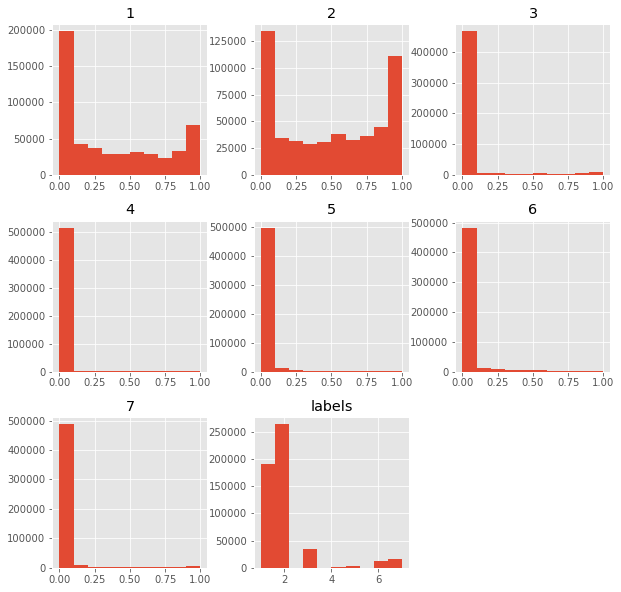

In [18]:
pd.DataFrame.hist(df_shadow
                  , figsize = [10,10]
                 );

In [19]:
df_shadow.describe()

,1,2,3,4,5,6,7,labels
count,522909.000000,522909.000000,522909.000000,522909.000000,522909.000000,522909.000000,522909.000000,522909.000000
mean,0.364708,0.487127,0.061806,0.004781,0.016438,0.029977,0.035162,1.978656
std,0.360108,0.371711,0.198182,0.049398,0.072467,0.113889,0.148355,1.286443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.093023,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.257143,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.686275,0.847826,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


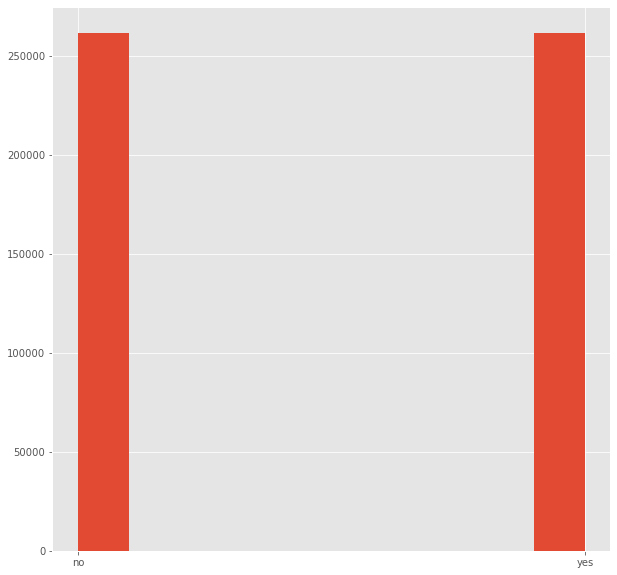

In [20]:
plt.hist(df_shadow['training'])
plt.show()

## part 4 - train the attack classifier
- train shadow attacker

In [21]:
attacker_target_name = 'training'

X_attacker = df_shadow.drop([attacker_target_name], axis = 1) # drop the class column
y_attacker = df_shadow[attacker_target_name] # Class only

print(X_attacker.shape)
print(y_attacker.shape)

(522909, 8)
(522909,)


In [22]:
Xtrain_attacker, Xtest_attacker, ytrain_attacker, ytest_attacker = train_test_split(X_attacker,y_attacker, random_state = random_state)  

print(Xtrain_attacker.shape, Xtest_attacker.shape, ytrain_attacker.shape, ytest_attacker.shape)
print('There are', Xtrain_attacker.shape[0], 'samples in the training dataset')
print('There are', Xtest_attacker.shape[0], 'samples in the testing dataset')
print('Each sample has', len(Xtrain_attacker.columns), 'features')

(392181, 8) (130728, 8) (392181,) (130728,)
There are 392181 samples in the training dataset
There are 130728 samples in the testing dataset
Each sample has 8 features


In [23]:
model_attacker = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=40, max_depth=20)
model_attacker.fit(X = Xtrain_attacker, y = ytrain_attacker)
ytrain_model_attacker = model_attacker.predict(Xtrain_attacker)

shadow_train_accurancy = accuracy_score(ytrain_attacker, ytrain_model_attacker)*100

print('The accuracy on training set is', shadow_train_accurancy, '%')

ytest_model_attacker = model_attacker.predict(Xtest_attacker)

shadow_test_accurancy = accuracy_score(ytest_attacker, ytest_model_attacker)*100

print('The accuracy on testing set is',shadow_test_accurancy, '%')

fitted_max_depth = model_attacker.tree_.max_depth
print('The maximum depth of the tree fitted on X_train is', fitted_max_depth)

print(confusion_matrix(y_true = ytest_attacker, y_pred = ytest_model_attacker))
print(classification_report(ytest_attacker, ytest_model_attacker))

The accuracy on training set is 51.29213296921574 %
The accuracy on testing set is 50.43448993329661 %
The maximum depth of the tree fitted on X_train is 20
[[30167 35053]
 [29743 35765]]
              precision    recall  f1-score   support

          no       0.50      0.46      0.48     65220
         yes       0.51      0.55      0.52     65508

    accuracy                           0.50    130728
   macro avg       0.50      0.50      0.50    130728
weighted avg       0.50      0.50      0.50    130728



In [24]:
df_shadows = []

for i in range(min_feature, max_feature+1, 1):
    df_shadows.append(df_shadow[df_shadow['labels'] == i])

attacker_target_name = 'training'

X_attacker = []
y_attacker = []

for df_shadow in df_shadows:
    X_attacker.append(df_shadow.drop([attacker_target_name], axis = 1)) # drop the class column
    y_attacker.append(df_shadow[attacker_target_name]) # Class only

print(X_attacker[0].shape)
print(y_attacker[0].shape)

Xtrain_attackers = []
Xtest_attackers = []
ytrain_attackers = []
ytest_attackers = []

for i in range(0,len(X_attacker),1):
    Xtrain_attacker, Xtest_attacker, ytrain_attacker, ytest_attacker = train_test_split(X_attacker[i], y_attacker[i], random_state = random_state)  

    Xtrain_attackers.append(Xtrain_attacker)
    Xtest_attackers.append(Xtest_attacker)
    ytrain_attackers.append(ytrain_attacker)
    ytest_attackers.append(ytest_attacker)
                      
             
print(Xtrain_attackers[0].shape, Xtest_attackers[0].shape, ytrain_attackers[0].shape, ytest_attackers[0].shape)
print('There are', Xtrain_attackers[0].shape[0], 'samples in the training dataset')
print('There are', Xtest_attackers[0].shape[0], 'samples in the testing dataset')
print('Each sample has', len(Xtrain_attackers[0].columns), 'features')

(190074, 8)
(190074,)
(142555, 8) (47519, 8) (142555,) (47519,)
There are 142555 samples in the training dataset
There are 47519 samples in the testing dataset
Each sample has 8 features


In [25]:
model_attacker = []
max_depths = [28,28,25,8,14,28,30]
min_sample_leaves = [20,20,20,20,20,20,20]

for i in range(0,len(Xtrain_attackers),1):
    print(i)
    model_attacker.append(DecisionTreeClassifier(criterion="entropy", min_samples_leaf = min_sample_leaves[i], max_depth=max_depths[i]))
    model_attacker[i].fit(X = Xtrain_attackers[i], y = ytrain_attackers[i])
    ytrain_model_attacker = model_attacker[i].predict(Xtrain_attackers[i])

    shadow_train_accurancy = accuracy_score(ytrain_attackers[i], ytrain_model_attacker)*100

    print('The accuracy on training set is', shadow_train_accurancy, '%')

    ytest_model_attacker = model_attacker[i].predict(Xtest_attackers[i])

    shadow_test_accurancy = accuracy_score(ytest_attackers[i], ytest_model_attacker)*100

    print('The accuracy on testing set is',shadow_test_accurancy, '%')

    fitted_max_depth = model_attacker[i].tree_.max_depth
    print('The maximum depth of the tree fitted on X_train is', fitted_max_depth)

    #print(confusion_matrix(y_true = ytest_attackers[i], y_pred = ytest_model_attacker))
    #print(classification_report(ytest_attackers[i], ytest_model_attacker))

0
The accuracy on training set is 52.56287047104627 %
The accuracy on testing set is 50.379848060775686 %
The maximum depth of the tree fitted on X_train is 28
1
The accuracy on training set is 52.12265696270797 %
The accuracy on testing set is 50.297871053586555 %
The maximum depth of the tree fitted on X_train is 28
2
The accuracy on training set is 54.38882421420256 %
The accuracy on testing set is 50.06402048655569 %
The maximum depth of the tree fitted on X_train is 25
3
The accuracy on training set is 54.97752087347463 %
The accuracy on testing set is 50.481695568400774 %
The maximum depth of the tree fitted on X_train is 8
4
The accuracy on training set is 55.12337933918863 %
The accuracy on testing set is 51.253132832080205 %
The maximum depth of the tree fitted on X_train is 10
5
The accuracy on training set is 55.13230900554844 %
The accuracy on testing set is 50.336000000000006 %
The maximum depth of the tree fitted on X_train is 17
6
The accuracy on training set is 53.81824

## part 5 - performing the custom attack
- attack the trained model

In [26]:
#shouffle dataset
#test using label in the training of the attacker

guesses_defender = []
labels_defender = [] #truth labels from the dataset
training_defender = []
predicted_labels = [] #labels as the model predicted them

#remember: yprob_model_train is the probability predicted by the target model on Xtrain

for j in yprob_model_train: #to concatenate the lists
    guesses_defender.append(j)
for j in ytrain:
    labels_defender.append(j)
for j in ytrain_model:
    predicted_labels.append(j)
    
training_yes = len(guesses_defender)
    
for j in yprob_model_test:
    guesses_defender.append(j)
for j in ytest:
    labels_defender.append(j)
for j in ytest_model:
    predicted_labels.append(j)

training_no = len(guesses_defender) - training_yes
    
training_yes = ['yes'] * training_yes
training_no = ['no'] * training_no
training_defender = training_yes + training_no

df_defender = pd.DataFrame({'guesses': guesses_defender})
df_defender['training'] = training_defender
df_defender['labels'] = labels_defender
df_defender['predicted labels'] = predicted_labels

df_defender = df_defender.sample(frac=1).reset_index(drop=True)

df_predicted_label = df_defender['predicted labels']

classes = df_defender['labels'] #classes that each row of de df_defender classifier originally belongs to

columns = range(min_feature,min_feature+n_features,1)

df_defender_t = pd.DataFrame(df_defender['guesses'].to_list(), columns=columns)
df_defender_t['training'] = df_defender['training']
#df_defender_t['labels'] = df_defender['labels']
df_defender_t['labels'] = df_defender['predicted labels']

df_defender = df_defender_t

df_defender.head()

,1,2,3,4,5,6,7,training,labels
0,0.805556,0.194444,0.000000,0.0,0.000000,0.0,0.0,no,1
1,0.000000,0.723404,0.000000,0.0,0.276596,0.0,0.0,no,2
2,0.151515,0.848485,0.000000,0.0,0.000000,0.0,0.0,no,2
3,0.878049,0.121951,0.000000,0.0,0.000000,0.0,0.0,no,1
4,0.000000,0.645161,0.354839,0.0,0.000000,0.0,0.0,yes,2


array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'labels'}>, <AxesSubplot:>]],
      dtype=object)

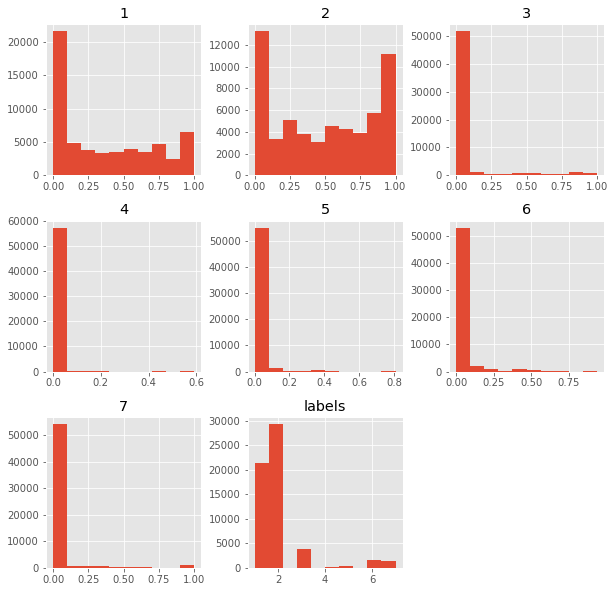

In [27]:
pd.DataFrame.hist(df_defender
                  , figsize = [10,10]
                 )

In [28]:
df_defenders = []

for i in range(min_feature, max_feature+1, 1):
    df_defenders.append(df_defender[df_defender['labels'] == i])

attacker_target_name = 'training'

X_attacker = []
y_attacker = []

for df_def in df_defenders:
    X_attacker.append(df_def.drop([attacker_target_name], axis = 1)) # drop the class column
    y_attacker.append(df_def[attacker_target_name]) # Class only

print(X_attacker[0].shape)
print(y_attacker[0].shape)

(21486, 8)
(21486,)


In [29]:
y_model_attack = []

for i in range(0,len(X_attacker),1):
    y_model_attack.append(model_attacker[i].predict(X_attacker[i]))

    r_attack_accurancy = accuracy_score(y_attacker[i], y_model_attack[i])*100

    print('The accuracy on the attack is', r_attack_accurancy, '%')

    print(confusion_matrix(y_true = y_attacker[i], y_pred = y_model_attack[i]))
    print(classification_report(y_attacker[i], y_model_attack[i]))

The accuracy on the attack is 49.07846970120078 %
[[7233 7813]
 [3128 3312]]
              precision    recall  f1-score   support

          no       0.70      0.48      0.57     15046
         yes       0.30      0.51      0.38      6440

    accuracy                           0.49     21486
   macro avg       0.50      0.50      0.47     21486
weighted avg       0.58      0.49      0.51     21486

The accuracy on the attack is 46.0396376762242 %
[[ 8142 12386]
 [ 3460  5378]]
              precision    recall  f1-score   support

          no       0.70      0.40      0.51     20528
         yes       0.30      0.61      0.40      8838

    accuracy                           0.46     29366
   macro avg       0.50      0.50      0.46     29366
weighted avg       0.58      0.46      0.48     29366

The accuracy on the attack is 46.9828722002635 %
[[1145 1507]
 [ 505  638]]
              precision    recall  f1-score   support

          no       0.69      0.43      0.53      2652
    

D:\Programmi\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programmi\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programmi\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programmi\Anaconda3\lib\site-packages\sklearn\metrics\_cla

In [30]:
for df_def in df_defenders:
    n_yes = df_def[df_def['training'] == 'yes'].shape[0]
    n_no = df_def[df_def['training'] == 'no'].shape[0]
    yes_perc = n_yes/df_def.shape[0]
    no_perc = n_no/df_def.shape[0]
    print("yes:" + str(yes_perc) + " no: " + str(no_perc))

yes:0.2997300567811598no: 0.7002699432188402
yes:0.3009602942178029no: 0.6990397057821971
yes:0.3011857707509881no: 0.6988142292490118
yes:0.2894736842105263no: 0.7105263157894737
yes:0.3082191780821918no: 0.6917808219178082
yes:0.29539473684210527no: 0.7046052631578947
yes:0.2859060402684564no: 0.7140939597315437


In [31]:
test = classes[y_attack == y_model_attack]

classes_sum = classes.value_counts()
test_sum = test.value_counts()

class_accuracy = []

sorted_labels = pd.unique(df[target_name])
sorted_labels.sort()

for c in (sorted_labels):
    print("{} {}/{} = {:.3f}".format(c,test_sum.loc[c], classes_sum.loc[c], test_sum.loc[c]/classes_sum.loc[c]))

NameError: name 'y_attack' is not defined

In [ ]:
#same as above, but considering only the classes that are in the dataset

i = 0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a==b and a=='yes' and b=='yes'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

i = 0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a==b and a=='no' and b=='no'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

i = 0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a!=b and a=='no' and b=='yes'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

i=0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a!=b and a=='yes' and b=='no'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

In [ ]:
#use code from the paper: try to use the same model on the evaluation and the shadow + same

#outputs + labels

print('The target model accuracy on training set is', target_train_accurancy, '%')

print('The target model accuracy on testing set is', target_test_accurancy, '%')

print('-------------------------------------------')

print('The shadow model accuracy on training set is', shadow_train_accurancy, '%')

print('The shadow model accuracy on testing set is', shadow_test_accurancy, '%')

print('The accuracy on the attack is', r_attack_accurancy, '%')

print('-------------------------------------------')

#print a graph of the class % that the attack has guessed correctly

MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,target_train_performance,target_test_performance,num_classes=n_features)

print("MIA evaluation with shadow != model")

MIA._mem_inf_benchmarks()

print('-------------------------------------------')

MIA = black_box_benchmarks(target_shadow_train_performance,target_shadow_test_performance,target_train_performance,target_test_performance,num_classes=n_features)

print("MIA evaluation with shadow = model")

MIA._mem_inf_benchmarks()

In [ ]:
#tr_values is the training data used for the shadow classifier
#te_values is the testing data used for the shadow classifier

#tr_labels is the y of the training data used for the shadow classifier
#te_labes is the y of the testing data used for the shadow classifier

#data values values from the target classifier
#data labels labels from the target classifier

risk_score = calculate_risk_score(MIA.s_tr_m_entr, MIA.s_te_m_entr, MIA.s_tr_labels, MIA.s_te_labels, MIA.t_tr_m_entr, MIA.t_tr_labels, log_bins=True)

In [ ]:
MIA = black_box_benchmarks(miss_shadow_train_performance,miss_shadow_test_performance,miss_target_train_performance,miss_target_test_performance,num_classes=n_features)

print("MIA evaluation with shadow != model MISSclassification")

MIA._mem_inf_benchmarks()

MIA = black_box_benchmarks(miss_shadow_train_performance,miss_shadow_test_performance,class_target_train_performance,class_target_test_performance,num_classes=n_features)

print("\nMIA evaluation with shadow != model correct classification")

MIA._mem_inf_benchmarks()